# Loading and Checking Data

## Importing Libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = torch.cuda.is_available()

## Loading Data

In [55]:
batch_size = 4

# These are the mean and standard deviation values for all pictures in the training set.
mean = (0.4914 ,  0.48216,  0.44653)
std = (0.24703,  0.24349,  0.26159)

# Class to denormalize images to display later.
class DeNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

# Creating instance of Functor
denorm = DeNormalize(mean, std)

# Load data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Do NOT shuffle the test set or else the order will be messed up
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

# Classes in order
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Sample Images and Labels

  dog truck   dog  bird


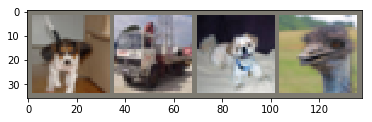

In [5]:
# functions to show an image
def imshow(img):
    img = denorm(img)    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Defining Model

## Fully-Connected DNN

In [6]:
class Net_DNN(nn.Module):
    def __init__(self, architecture):
        super().__init__()
        self.layers = nn.ModuleList([
                                    nn.Linear(architecture[layer], architecture[layer + 1]) 
                                    for layer in range(len(architecture) - 1)])
        
    def forward(self, data):
        # Flatten the Tensor (i.e., dimensions 3 x 32 x 32) to a single column
        data = data.view(data.size(0), -1)
        for layer in self.layers:
            layer_data = layer(data)
            data = F.relu(layer_data)
        return F.log_softmax(layer_data, dim=-1)

## Fully-CNN

In [33]:
class Net_CNN(nn.Module):
    # Padding is set to 2 and stride to 2
    # Padding ensures all edge pixels are exposed to the filter
    # Stride = 2 is common practice
    def __init__(self, layers, c, stride=2):
        super().__init__()
        self.layers = nn.ModuleList([
                                    nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, padding=2, stride=stride)
                                    for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1) # Simply takes the maximum value from the Tensor
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, data):
        for layer in self.layers: 
            data = F.relu(layer(data))
        data = self.pool(data)
        data = data.view(data.size(0), -1)
        return F.log_softmax(self.out(data), dim=-1)

## Chained CNN and NN

In [59]:
class Net_CNN_NN(nn.Module):
    # Padding is set to 2 and stride to 2
    # Padding ensures all edge pixels are exposed to the filter
    # Stride = 2 is common practice
    def __init__(self, layers, architecture, stride=2):
        super().__init__()
        # Fully Convolutional Layers
        self.layers = nn.ModuleList([
                                    nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, padding=2,stride=stride)
                                    for i in range(len(layers) - 1)])
        # Fully Connected Neural Network to map to output
        self.layers_NN = nn.ModuleList([
                                    nn.Linear(architecture[layer], architecture[layer + 1]) 
                                    for layer in range(len(architecture) - 1)])
        
        self.pool = nn.AdaptiveMaxPool2d(1) # Simply takes the maximum value from the Tensor
        
    def forward(self, data):
        for layer in self.layers: 
            data = F.relu(layer(data))
        data = self.pool(data)
        data = data.view(data.size(0), -1)
        for layer in self.layers_NN:
            layer_data = layer(data)
            data = F.relu(layer_data)
        
        return F.log_softmax(layer_data, dim=-1)

## Defining the NN, Loss Function and Optimizer

In [61]:
# ---------------------------------------------
# Uncomment the architecture you want to use
# ---------------------------------------------

# # DNN
# architecture = [32*32*3, 100, 100, 100, 100, 10]
# net = Net_DNN(architecture)

# # CNN
# architecture = [3, 20, 40, 80, 160]
# num_outputs = 10
# net = Net_CNN(architecture, num_outputs)

# # CNN with NN
# architecture = [3, 20, 40, 80]
# architecture_NN = [80, 40, 20, 10]
# num_outputs = 10
# net = Net_CNN_NN(architecture, architecture_NN)

if use_cuda:
    net = net.cuda() # Training on the GPU

criterion = nn.CrossEntropyLoss()

## Loading Model

In [50]:
# ---------------------------------------------
# Uncomment the architecture you want to use
# ---------------------------------------------

# # DNN
# architecture = [32*32*3, 100, 100, 10]
# net = Net_DNN(architecture)

# # CNN
# architecture = [3, 20, 40, 80, 160]
# num_outputs = 10
# net = Net_CNN(architecture, num_outputs)
# criterion = nn.CrossEntropyLoss()

if use_cuda:
    net = net.cuda() # Training on the GPU

# ---------------------------------------------
# Uetermine the path for the saved weights
# ---------------------------------------------
PATH = './checkpoints_CNN_v2/5'
# Load weights
net.load_state_dict(torch.load(PATH))

## Recording Loss

In [62]:
# Initialize a list of loss_results
loss_results = []

# Training Manual

In [65]:
# Set the Learning rate and epoch start and end points
start_epoch = 11
end_epoch = 15
lr = 0.0001
# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

for epoch in range(start_epoch, end_epoch+1):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # get the inputs
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels) # Inputs and Target values to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(running_loss / 2000)
            loss_results.append(running_loss / 2000)
            running_loss = 0.0
    PATH = './checkpoints_hybrid/' + str(epoch)
    torch.save(net.state_dict(), PATH)
        

Epoch: 11
0.7631593999336473
0.772029997533653
0.7622815664624796
0.7895928663983941
0.7818622282706201
0.7965481701032259
Epoch: 12
0.7587507799463347
0.7542067431546747
0.7607613385347649
0.7611085303728469
0.7500329479556531
0.768398270084057
Epoch: 13
0.7284724237506743
0.7313052681912668
0.7489473702453543
0.7530480517586693
0.7388339222935029
0.776530001245439
Epoch: 14
0.7227064029038883
0.7381190525260753
0.7362304750531912
0.7219595499557908
0.7571793817970902
0.7341004028483294
Epoch: 15
0.7172498370609246
0.7022846946662757
0.7447555431951769
0.7256098798593739
0.719516308715567
0.731529594759224


## Sample of the Results

GroundTruth:    cat  ship  ship plane


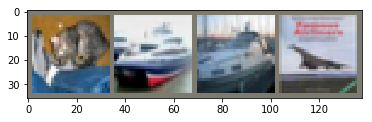

In [46]:
# load a min-batch of the images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Sample of Predictions

In [47]:
# For the images shown above, show the predictions
# first activate GPU processing
images, labels = images.cuda(), labels.cuda()

# Feed forward
outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


## Total Test Set Accuracy

In [66]:
# Small code snippet to determine test accuracy
correct = 0
total = 0
for data in testloader:
    # load images
    images, labels = data
    if use_cuda:
        images, labels = images.cuda(), labels.cuda()
    # feed forward
    outputs = net(Variable(images))
    # perform softmax regression
    _, predicted = torch.max(outputs.data, 1)
    # update stats
    total += labels.size(0)
    correct += (predicted == labels).sum()

# print the results
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 66 %


## Accuracy per Class for Test Set

In [67]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    if use_cuda:
        images, labels = images.cuda(), labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

# Print the accuracy per class
for i in range(10):
    print(classes[i], 100 * class_correct[i] / class_total[i])

69.7
79.4
58.9
55.5
55.8
56.8
70.1
69.0
77.7
75.4


# Plot Loss

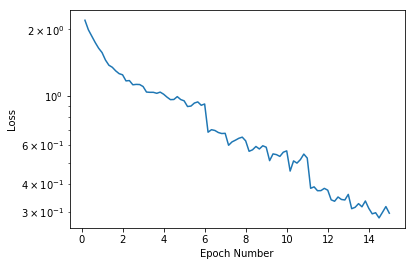

In [54]:
batch_size = 4
loss_samples_per_epoch = 6
num_epochs = 15
epochs_list = [(i/loss_samples_per_epoch) for i in range(1, num_epochs*loss_samples_per_epoch + 1)]  
plt.semilogy(epochs_list, loss_results[:-6])
plt.ylabel('Loss')
plt.xlabel('Epoch Number')
plt.savefig('./DNN_v2.png', format='png', pad_inches=1, dpi=1200)